In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [2]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

!pip install torchmetrics==0.7.3
import torchmetrics
criterion2 = smp.losses.DiceLoss(mode='multiclass')

     |████████████████████████████████| 88 kB 6.9 MB/s 
     |████████████████████████████████| 376 kB 32.4 MB/s 
     |████████████████████████████████| 58 kB 7.7 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=b84f1e002fa13890a33b94d56a3c757769aaad8fe954c99394d804c4c1369a0f
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=6c9d228a9726bb641d72f4368dea5866e4f7e66327fc636e9bb11e8a32c5392d
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
     |████████████████████████████████| 398 kB 14.1 MB/s 


In [3]:
import sys, os, time, pickle
import numpy as np
import math
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

import torch.optim as optim
!pip install torchsummary
from torchsummary import summary
!pip install einops
from math import ceil
import pywt

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

from torch import nn, einsum
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers
from einops import reduce



### Prepare Dataset

In [4]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
import tensorflow as tf

## Cifar 100 Dataset
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

2.8.0
169017344/169001437 [==============================] - 8s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


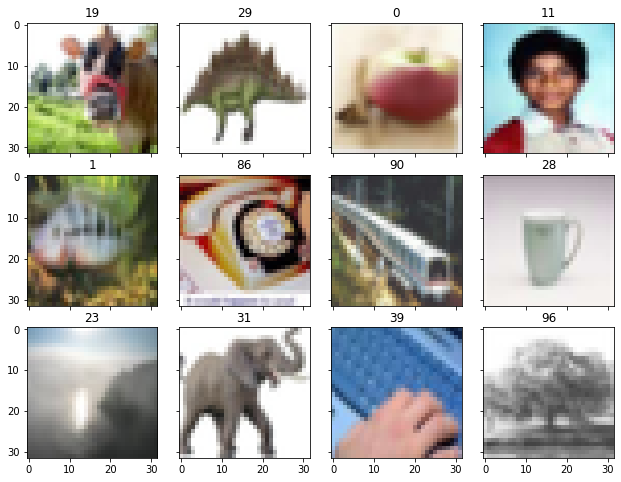

In [5]:
## Get first 32 images as samples
sample_images = x_train[:12]
sample_labels = y_train[:12]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3,4 ),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()

In [6]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=512, dim=(32, 32), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
  
      ## Get mask associated to that image
      masked_image = self.__createMask(image_copy)
      
      X_batch[i,] = masked_image/255
      y_batch[i] = self.y[idx]/255
      
    return X_batch, y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((32,32,3), 255, np.uint8)
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 4)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Perforn bitwise and operation to mak the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image


In [7]:

## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test, shuffle=False)

In [8]:
!pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 21.8 MB 14.7 MB/s 


In [9]:
!pip install -U albumentations

     |████████████████████████████████| 102 kB 15.5 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [10]:
# !pip uninstall torchmetrics
!pip install torchmetrics==0.7.3
import torchmetrics

In [11]:
# import torch
# import torch.nn.functional as F
# import numpy as np
# from torch.autograd import Function
# import pywt
# import torch.nn as nn
# import functools

# def sfb1d(lo, hi, g0, g1, mode='zero', dim=-1):
#     """ 1D synthesis filter bank of an image tensor
#     """
#     C = lo.shape[1]
#     d = dim % 4
#     # If g0, g1 are not tensors, make them. If they are, then assume that they
#     # are in the right order
#     if not isinstance(g0, torch.Tensor):
#         g0 = torch.tensor(np.copy(np.array(g0).ravel()),
#                           dtype=torch.float, device=lo.device)
#     if not isinstance(g1, torch.Tensor):
#         g1 = torch.tensor(np.copy(np.array(g1).ravel()),
#                           dtype=torch.float, device=lo.device)
#     L = g0.numel()
#     shape = [1,1,1,1]
#     shape[d] = L
#     N = 2*lo.shape[d]
#     # If g aren't in the right shape, make them so
#     if g0.shape != tuple(shape):
#         g0 = g0.reshape(*shape)
#     if g1.shape != tuple(shape):
#         g1 = g1.reshape(*shape)

#     s = (2, 1) if d == 2 else (1,2)
#     g0 = torch.cat([g0]*C,dim=0)
#     g1 = torch.cat([g1]*C,dim=0)
#     if mode == 'per' or mode == 'periodization':
#         y = F.conv_transpose2d(lo, g0, stride=s, groups=C) + \
#             F.conv_transpose2d(hi, g1, stride=s, groups=C)
#         if d == 2:
#             y[:,:,:L-2] = y[:,:,:L-2] + y[:,:,N:N+L-2]
#             y = y[:,:,:N]
#         else:
#             y[:,:,:,:L-2] = y[:,:,:,:L-2] + y[:,:,:,N:N+L-2]
#             y = y[:,:,:,:N]
#         y = roll(y, 1-L//2, dim=dim)
#     else:
#         if mode == 'zero' or mode == 'symmetric' or mode == 'reflect' or \
#                 mode == 'periodic':
#             pad = (L-2, 0) if d == 2 else (0, L-2)
#             y = F.conv_transpose2d(lo, g0, stride=s, padding=pad, groups=C) + \
#                 F.conv_transpose2d(hi, g1, stride=s, padding=pad, groups=C)
#         else:
#             raise ValueError("Unkown pad type: {}".format(mode))

#     return y

# def reflect(x, minx, maxx):
#     """Reflect the values in matrix *x* about the scalar values *minx* and
#     *maxx*.  Hence a vector *x* containing a long linearly increasing series is
#     converted into a waveform which ramps linearly up and down between *minx*
#     and *maxx*.  If *x* contains integers and *minx* and *maxx* are (integers +
#     0.5), the ramps will have repeated max and min samples.
#     .. codeauthor:: Rich Wareham <rjw57@cantab.net>, Aug 2013
#     .. codeauthor:: Nick Kingsbury, Cambridge University, January 1999.
#     """
#     x = np.asanyarray(x)
#     rng = maxx - minx
#     rng_by_2 = 2 * rng
#     mod = np.fmod(x - minx, rng_by_2)
#     normed_mod = np.where(mod < 0, mod + rng_by_2, mod)
#     out = np.where(normed_mod >= rng, rng_by_2 - normed_mod, normed_mod) + minx
#     return np.array(out, dtype=x.dtype)

# def mode_to_int(mode):
#     if mode == 'zero':
#         return 0
#     elif mode == 'symmetric':
#         return 1
#     elif mode == 'per' or mode == 'periodization':
#         return 2
#     elif mode == 'constant':
#         return 3
#     elif mode == 'reflect':
#         return 4
#     elif mode == 'replicate':
#         return 5
#     elif mode == 'periodic':
#         return 6
#     else:
#         raise ValueError("Unkown pad type: {}".format(mode))

# def int_to_mode(mode):
#     if mode == 0:
#         return 'zero'
#     elif mode == 1:
#         return 'symmetric'
#     elif mode == 2:
#         return 'periodization'
#     elif mode == 3:
#         return 'constant'
#     elif mode == 4:
#         return 'reflect'
#     elif mode == 5:
#         return 'replicate'
#     elif mode == 6:
#         return 'periodic'
#     else:
#         raise ValueError("Unkown pad type: {}".format(mode))

# def afb1d(x, h0, h1, mode='zero', dim=-1):
#     """ 1D analysis filter bank (along one dimension only) of an image
#     Inputs:
#         x (tensor): 4D input with the last two dimensions the spatial input
#         h0 (tensor): 4D input for the lowpass filter. Should have shape (1, 1,
#             h, 1) or (1, 1, 1, w)
#         h1 (tensor): 4D input for the highpass filter. Should have shape (1, 1,
#             h, 1) or (1, 1, 1, w)
#         mode (str): padding method
#         dim (int) - dimension of filtering. d=2 is for a vertical filter (called
#             column filtering but filters across the rows). d=3 is for a
#             horizontal filter, (called row filtering but filters across the
#             columns).
#     Returns:
#         lohi: lowpass and highpass subbands concatenated along the channel
#             dimension
#     """
#     C = x.shape[1]
#     # Convert the dim to positive
#     d = dim % 4
#     s = (2, 1) if d == 2 else (1, 2)
#     N = x.shape[d]
#     # If h0, h1 are not tensors, make them. If they are, then assume that they
#     # are in the right order
#     if not isinstance(h0, torch.Tensor):
#         h0 = torch.tensor(np.copy(np.array(h0).ravel()[::-1]),
#                           dtype=torch.float, device=x.device)
#     if not isinstance(h1, torch.Tensor):
#         h1 = torch.tensor(np.copy(np.array(h1).ravel()[::-1]),
#                           dtype=torch.float, device=x.device)
#     L = h0.numel()
#     L2 = L // 2
#     shape = [1,1,1,1]
#     shape[d] = L
#     # If h aren't in the right shape, make them so
#     if h0.shape != tuple(shape):
#         h0 = h0.reshape(*shape)
#     if h1.shape != tuple(shape):
#         h1 = h1.reshape(*shape)
#     h = torch.cat([h0, h1] * C, dim=0)

#     if mode == 'per' or mode == 'periodization':
#         if x.shape[dim] % 2 == 1:
#             if d == 2:
#                 x = torch.cat((x, x[:,:,-1:]), dim=2)
#             else:
#                 x = torch.cat((x, x[:,:,:,-1:]), dim=3)
#             N += 1
#         x = roll(x, -L2, dim=d)
#         pad = (L-1, 0) if d == 2 else (0, L-1)
#         lohi = F.conv2d(x, h, padding=pad, stride=s, groups=C)
#         N2 = N//2
#         if d == 2:
#             lohi[:,:,:L2] = lohi[:,:,:L2] + lohi[:,:,N2:N2+L2]
#             lohi = lohi[:,:,:N2]
#         else:
#             lohi[:,:,:,:L2] = lohi[:,:,:,:L2] + lohi[:,:,:,N2:N2+L2]
#             lohi = lohi[:,:,:,:N2]
#     else:
#         # Calculate the pad size
#         outsize = pywt.dwt_coeff_len(N, L, mode=mode)
#         p = 2 * (outsize - 1) - N + L
#         if mode == 'zero':
#             # Sadly, pytorch only allows for same padding before and after, if
#             # we need to do more padding after for odd length signals, have to
#             # prepad
#             if p % 2 == 1:
#                 pad = (0, 0, 0, 1) if d == 2 else (0, 1, 0, 0)
#                 x = F.pad(x, pad)
#             pad = (p//2, 0) if d == 2 else (0, p//2)
#             # Calculate the high and lowpass
#             lohi = F.conv2d(x, h, padding=pad, stride=s, groups=C)
#         elif mode == 'symmetric' or mode == 'reflect' or mode == 'periodic':
#             pad = (0, 0, p//2, (p+1)//2) if d == 2 else (p//2, (p+1)//2, 0, 0)
#             x = mypad(x, pad=pad, mode=mode)
#             lohi = F.conv2d(x, h, stride=s, groups=C)
#         else:
#             raise ValueError("Unkown pad type: {}".format(mode))

#     return lohi



# class AFB2D(Function):
#     """ Does a single level 2d wavelet decomposition of an input. Does separate
#     row and column filtering by two calls to
#     :py:func:`pytorch_wavelets.dwt.lowlevel.afb1d`
#     Needs to have the tensors in the right form. Because this function defines
#     its own backward pass, saves on memory by not having to save the input
#     tensors.
#     Inputs:
#         x (torch.Tensor): Input to decompose
#         h0_row: row lowpass
#         h1_row: row highpass
#         h0_col: col lowpass
#         h1_col: col highpass
#         mode (int): use mode_to_int to get the int code here
#     We encode the mode as an integer rather than a string as gradcheck causes an
#     error when a string is provided.
#     Returns:
#         y: Tensor of shape (N, C*4, H, W)
#     """
#     @staticmethod
#     def forward(ctx, x, h0_row, h1_row, h0_col, h1_col, mode):
#         ctx.save_for_backward(h0_row, h1_row, h0_col, h1_col)
#         ctx.shape = x.shape[-2:]
#         mode = int_to_mode(mode)
#         ctx.mode = mode
#         lohi = afb1d(x, h0_row, h1_row, mode=mode, dim=3)
#         y = afb1d(lohi, h0_col, h1_col, mode=mode, dim=2)
#         s = y.shape
#         y = y.reshape(s[0], -1, 4, s[-2], s[-1])
#         low = y[:,:,0].contiguous()
#         highs = y[:,:,1:].contiguous()
#         return low, highs

#     @staticmethod
#     def backward(ctx, low, highs):
#         dx = None
#         if ctx.needs_input_grad[0]:
#             mode = ctx.mode
#             h0_row, h1_row, h0_col, h1_col = ctx.saved_tensors
#             lh, hl, hh = torch.unbind(highs, dim=2)
#             lo = sfb1d(low, lh, h0_col, h1_col, mode=mode, dim=2)
#             hi = sfb1d(hl, hh, h0_col, h1_col, mode=mode, dim=2)
#             dx = sfb1d(lo, hi, h0_row, h1_row, mode=mode, dim=3)
#             if dx.shape[-2] > ctx.shape[-2] and dx.shape[-1] > ctx.shape[-1]:
#                 dx = dx[:,:,:ctx.shape[-2], :ctx.shape[-1]]
#             elif dx.shape[-2] > ctx.shape[-2]:
#                 dx = dx[:,:,:ctx.shape[-2]]
#             elif dx.shape[-1] > ctx.shape[-1]:
#                 dx = dx[:,:,:,:ctx.shape[-1]]
#         return dx, None, None, None, None, None


# def prep_filt_afb2d(h0_col, h1_col, h0_row=None, h1_row=None, device=device):
#     """
#     Prepares the filters to be of the right form for the afb2d function.  In
#     particular, makes the tensors the right shape. It takes mirror images of
#     them as as afb2d uses conv2d which acts like normal correlation.
#     Inputs:
#         h0_col (array-like): low pass column filter bank
#         h1_col (array-like): high pass column filter bank
#         h0_row (array-like): low pass row filter bank. If none, will assume the
#             same as column filter
#         h1_row (array-like): high pass row filter bank. If none, will assume the
#             same as column filter
#         device: which device to put the tensors on to
#     Returns:
#         (h0_col, h1_col, h0_row, h1_row)
#     """
#     h0_col, h1_col = prep_filt_afb1d(h0_col, h1_col, device)
#     if h0_row is None:
#         h0_row, h1_col = h0_col, h1_col
#     else:
#         h0_row, h1_row = prep_filt_afb1d(h0_row, h1_row, device)

#     h0_col = h0_col.reshape((1, 1, -1, 1))
#     h1_col = h1_col.reshape((1, 1, -1, 1))
#     h0_row = h0_row.reshape((1, 1, 1, -1))
#     h1_row = h1_row.reshape((1, 1, 1, -1))
#     return h0_col, h1_col, h0_row, h1_row


# def prep_filt_afb1d(h0, h1, device=device):
#     """
#     Prepares the filters to be of the right form for the afb2d function.  In
#     particular, makes the tensors the right shape. It takes mirror images of
#     them as as afb2d uses conv2d which acts like normal correlation.
#     Inputs:
#         h0 (array-like): low pass column filter bank
#         h1 (array-like): high pass column filter bank
#         device: which device to put the tensors on to
#     Returns:
#         (h0, h1)
#     """
#     h0 = np.array(h0[::-1]).ravel()
#     h1 = np.array(h1[::-1]).ravel()
#     t = torch.get_default_dtype()
#     h0 = torch.tensor(h0, device=device, dtype=t).reshape((1, 1, -1))
#     h1 = torch.tensor(h1, device=device, dtype=t).reshape((1, 1, -1))
#     return h0, h1

# class DWTForward(nn.Module):
#     """ Performs a 2d DWT Forward decomposition of an image
#     Args:
#         J (int): Number of levels of decomposition
#         wave (str or pywt.Wavelet or tuple(ndarray)): Which wavelet to use.
#             Can be:
#             1) a string to pass to pywt.Wavelet constructor
#             2) a pywt.Wavelet class
#             3) a tuple of numpy arrays, either (h0, h1) or (h0_col, h1_col, h0_row, h1_row)
#         mode (str): 'zero', 'symmetric', 'reflect' or 'periodization'. The
#             padding scheme
#         """
#     def __init__(self, J=1, wave='db1', mode='zero'):
#         super().__init__()
#         if isinstance(wave, str):
#             wave = pywt.Wavelet(wave)
#         if isinstance(wave, pywt.Wavelet):
#             h0_col, h1_col = wave.dec_lo, wave.dec_hi
#             h0_row, h1_row = h0_col, h1_col
#         else:
#             if len(wave) == 2:
#                 h0_col, h1_col = wave[0], wave[1]
#                 h0_row, h1_row = h0_col, h1_col
#             elif len(wave) == 4:
#                 h0_col, h1_col = wave[0], wave[1]
#                 h0_row, h1_row = wave[2], wave[3]

#         # Prepare the filters
#         filts = prep_filt_afb2d(h0_col, h1_col, h0_row, h1_row)
#         self.register_buffer('h0_col', filts[0])
#         self.register_buffer('h1_col', filts[1])
#         self.register_buffer('h0_row', filts[2])
#         self.register_buffer('h1_row', filts[3])
#         self.J = J
#         self.mode = mode

#     def forward(self, x):
#         """ Forward pass of the DWT.
#         Args:
#             x (tensor): Input of shape :math:`(N, C_{in}, H_{in}, W_{in})`
#         Returns:
#             (yl, yh)
#                 tuple of lowpass (yl) and bandpass (yh) coefficients.
#                 yh is a list of length J with the first entry
#                 being the finest scale coefficients. yl has shape
#                 :math:`(N, C_{in}, H_{in}', W_{in}')` and yh has shape
#                 :math:`list(N, C_{in}, 3, H_{in}'', W_{in}'')`. The new
#                 dimension in yh iterates over the LH, HL and HH coefficients.
#         Note:
#             :math:`H_{in}', W_{in}', H_{in}'', W_{in}''` denote the correctly
#             downsampled shapes of the DWT pyramid.
#         """
#         yh = []
#         ll = x
#         mode = mode_to_int(self.mode)

#         # Do a multilevel transform
#         for j in range(self.J):
#             # Do 1 level of the transform
#             ll, high = AFB2D.apply(
#                 ll, self.h0_col, self.h1_col, self.h0_row, self.h1_row, mode)
#             yh.append(high)

#         return ll, yh



    

In [12]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.autograd import Function
import pywt
import torch.nn as nn
import functools

def sfb1d(lo, hi, g0, g1, mode='zero', dim=-1):
    """ 1D synthesis filter bank of an image tensor
    """
    C = lo.shape[1]
    d = dim % 4
    # If g0, g1 are not tensors, make them. If they are, then assume that they
    # are in the right order
    if not isinstance(g0, torch.Tensor):
        g0 = torch.tensor(np.copy(np.array(g0).ravel()),
                          dtype=torch.float, device=lo.device)
    if not isinstance(g1, torch.Tensor):
        g1 = torch.tensor(np.copy(np.array(g1).ravel()),
                          dtype=torch.float, device=lo.device)
    L = g0.numel()
    shape = [1,1,1,1]
    shape[d] = L
    N = 2*lo.shape[d]
    # If g aren't in the right shape, make them so
    if g0.shape != tuple(shape):
        g0 = g0.reshape(*shape)
    if g1.shape != tuple(shape):
        g1 = g1.reshape(*shape)

    s = (2, 1) if d == 2 else (1,2)
    g0 = torch.cat([g0]*C,dim=0)
    g1 = torch.cat([g1]*C,dim=0)
    if mode == 'per' or mode == 'periodization':
        y = F.conv_transpose2d(lo, g0, stride=s, groups=C) + \
            F.conv_transpose2d(hi, g1, stride=s, groups=C)
        if d == 2:
            y[:,:,:L-2] = y[:,:,:L-2] + y[:,:,N:N+L-2]
            y = y[:,:,:N]
        else:
            y[:,:,:,:L-2] = y[:,:,:,:L-2] + y[:,:,:,N:N+L-2]
            y = y[:,:,:,:N]
        y = roll(y, 1-L//2, dim=dim)
    else:
        if mode == 'zero' or mode == 'symmetric' or mode == 'reflect' or \
                mode == 'periodic':
            pad = (L-2, 0) if d == 2 else (0, L-2)
            y = F.conv_transpose2d(lo, g0, stride=s, padding=pad, groups=C) + \
                F.conv_transpose2d(hi, g1, stride=s, padding=pad, groups=C)
        else:
            raise ValueError("Unkown pad type: {}".format(mode))

    return y

def reflect(x, minx, maxx):
    """Reflect the values in matrix *x* about the scalar values *minx* and
    *maxx*.  Hence a vector *x* containing a long linearly increasing series is
    converted into a waveform which ramps linearly up and down between *minx*
    and *maxx*.  If *x* contains integers and *minx* and *maxx* are (integers +
    0.5), the ramps will have repeated max and min samples.
    .. codeauthor:: Rich Wareham <rjw57@cantab.net>, Aug 2013
    .. codeauthor:: Nick Kingsbury, Cambridge University, January 1999.
    """
    x = np.asanyarray(x)
    rng = maxx - minx
    rng_by_2 = 2 * rng
    mod = np.fmod(x - minx, rng_by_2)
    normed_mod = np.where(mod < 0, mod + rng_by_2, mod)
    out = np.where(normed_mod >= rng, rng_by_2 - normed_mod, normed_mod) + minx
    return np.array(out, dtype=x.dtype)

def mode_to_int(mode):
    if mode == 'zero':
        return 0
    elif mode == 'symmetric':
        return 1
    elif mode == 'per' or mode == 'periodization':
        return 2
    elif mode == 'constant':
        return 3
    elif mode == 'reflect':
        return 4
    elif mode == 'replicate':
        return 5
    elif mode == 'periodic':
        return 6
    else:
        raise ValueError("Unkown pad type: {}".format(mode))

def int_to_mode(mode):
    if mode == 0:
        return 'zero'
    elif mode == 1:
        return 'symmetric'
    elif mode == 2:
        return 'periodization'
    elif mode == 3:
        return 'constant'
    elif mode == 4:
        return 'reflect'
    elif mode == 5:
        return 'replicate'
    elif mode == 6:
        return 'periodic'
    else:
        raise ValueError("Unkown pad type: {}".format(mode))

def afb1d(x, h0, h1, mode='zero', dim=-1):
    """ 1D analysis filter bank (along one dimension only) of an image
    Inputs:
        x (tensor): 4D input with the last two dimensions the spatial input
        h0 (tensor): 4D input for the lowpass filter. Should have shape (1, 1,
            h, 1) or (1, 1, 1, w)
        h1 (tensor): 4D input for the highpass filter. Should have shape (1, 1,
            h, 1) or (1, 1, 1, w)
        mode (str): padding method
        dim (int) - dimension of filtering. d=2 is for a vertical filter (called
            column filtering but filters across the rows). d=3 is for a
            horizontal filter, (called row filtering but filters across the
            columns).
    Returns:
        lohi: lowpass and highpass subbands concatenated along the channel
            dimension
    """
    C = x.shape[1]
    # Convert the dim to positive
    d = dim % 4
    s = (2, 1) if d == 2 else (1, 2)
    N = x.shape[d]
    # If h0, h1 are not tensors, make them. If they are, then assume that they
    # are in the right order
    if not isinstance(h0, torch.Tensor):
        h0 = torch.tensor(np.copy(np.array(h0).ravel()[::-1]),
                          dtype=torch.float, device=x.device)
    if not isinstance(h1, torch.Tensor):
        h1 = torch.tensor(np.copy(np.array(h1).ravel()[::-1]),
                          dtype=torch.float, device=x.device)
    L = h0.numel()
    L2 = L // 2
    shape = [1,1,1,1]
    shape[d] = L
    # If h aren't in the right shape, make them so
    if h0.shape != tuple(shape):
        h0 = h0.reshape(*shape)
    if h1.shape != tuple(shape):
        h1 = h1.reshape(*shape)
    h = torch.cat([h0, h1] * C, dim=0)

    if mode == 'per' or mode == 'periodization':
        if x.shape[dim] % 2 == 1:
            if d == 2:
                x = torch.cat((x, x[:,:,-1:]), dim=2)
            else:
                x = torch.cat((x, x[:,:,:,-1:]), dim=3)
            N += 1
        x = roll(x, -L2, dim=d)
        pad = (L-1, 0) if d == 2 else (0, L-1)
        lohi = F.conv2d(x, h, padding=pad, stride=s, groups=C)
        N2 = N//2
        if d == 2:
            lohi[:,:,:L2] = lohi[:,:,:L2] + lohi[:,:,N2:N2+L2]
            lohi = lohi[:,:,:N2]
        else:
            lohi[:,:,:,:L2] = lohi[:,:,:,:L2] + lohi[:,:,:,N2:N2+L2]
            lohi = lohi[:,:,:,:N2]
    else:
        # Calculate the pad size
        outsize = pywt.dwt_coeff_len(N, L, mode=mode)
        p = 2 * (outsize - 1) - N + L
        if mode == 'zero':
            # Sadly, pytorch only allows for same padding before and after, if
            # we need to do more padding after for odd length signals, have to
            # prepad
            if p % 2 == 1:
                pad = (0, 0, 0, 1) if d == 2 else (0, 1, 0, 0)
                x = F.pad(x, pad)
            pad = (p//2, 0) if d == 2 else (0, p//2)
            # Calculate the high and lowpass
            lohi = F.conv2d(x, h, padding=pad, stride=s, groups=C)
        elif mode == 'symmetric' or mode == 'reflect' or mode == 'periodic':
            pad = (0, 0, p//2, (p+1)//2) if d == 2 else (p//2, (p+1)//2, 0, 0)
            x = mypad(x, pad=pad, mode=mode)
            lohi = F.conv2d(x, h, stride=s, groups=C)
        else:
            raise ValueError("Unkown pad type: {}".format(mode))

    return lohi



class AFB2D(Function):
    """ Does a single level 2d wavelet decomposition of an input. Does separate
    row and column filtering by two calls to
    :py:func:`pytorch_wavelets.dwt.lowlevel.afb1d`
    Needs to have the tensors in the right form. Because this function defines
    its own backward pass, saves on memory by not having to save the input
    tensors.
    Inputs:
        x (torch.Tensor): Input to decompose
        h0_row: row lowpass
        h1_row: row highpass
        h0_col: col lowpass
        h1_col: col highpass
        mode (int): use mode_to_int to get the int code here
    We encode the mode as an integer rather than a string as gradcheck causes an
    error when a string is provided.
    Returns:
        y: Tensor of shape (N, C*4, H, W)
    """
    @staticmethod
    def forward(ctx, x, h0_row, h1_row, h0_col, h1_col, mode):
        ctx.save_for_backward(h0_row, h1_row, h0_col, h1_col)
        ctx.shape = x.shape[-2:]
        mode = int_to_mode(mode)
        ctx.mode = mode
        lohi = afb1d(x, h0_row, h1_row, mode=mode, dim=3)
        y = afb1d(lohi, h0_col, h1_col, mode=mode, dim=2)
        s = y.shape
        y = y.reshape(s[0], -1, 4, s[-2], s[-1])
        low = y[:,:,0].contiguous()
        highs = y[:,:,1:].contiguous()
        return low, highs

    @staticmethod
    def backward(ctx, low, highs):
        dx = None
        if ctx.needs_input_grad[0]:
            mode = ctx.mode
            h0_row, h1_row, h0_col, h1_col = ctx.saved_tensors
            lh, hl, hh = torch.unbind(highs, dim=2)
            lo = sfb1d(low, lh, h0_col, h1_col, mode=mode, dim=2)
            hi = sfb1d(hl, hh, h0_col, h1_col, mode=mode, dim=2)
            dx = sfb1d(lo, hi, h0_row, h1_row, mode=mode, dim=3)
            if dx.shape[-2] > ctx.shape[-2] and dx.shape[-1] > ctx.shape[-1]:
                dx = dx[:,:,:ctx.shape[-2], :ctx.shape[-1]]
            elif dx.shape[-2] > ctx.shape[-2]:
                dx = dx[:,:,:ctx.shape[-2]]
            elif dx.shape[-1] > ctx.shape[-1]:
                dx = dx[:,:,:,:ctx.shape[-1]]
        return dx, None, None, None, None, None


def prep_filt_afb2d(h0_col, h1_col, h0_row=None, h1_row=None, device=device):
    """
    Prepares the filters to be of the right form for the afb2d function.  In
    particular, makes the tensors the right shape. It takes mirror images of
    them as as afb2d uses conv2d which acts like normal correlation.
    Inputs:
        h0_col (array-like): low pass column filter bank
        h1_col (array-like): high pass column filter bank
        h0_row (array-like): low pass row filter bank. If none, will assume the
            same as column filter
        h1_row (array-like): high pass row filter bank. If none, will assume the
            same as column filter
        device: which device to put the tensors on to
    Returns:
        (h0_col, h1_col, h0_row, h1_row)
    """
    h0_col, h1_col = prep_filt_afb1d(h0_col, h1_col, device)
    if h0_row is None:
        h0_row, h1_col = h0_col, h1_col
    else:
        h0_row, h1_row = prep_filt_afb1d(h0_row, h1_row, device)

    h0_col = h0_col.reshape((1, 1, -1, 1))
    h1_col = h1_col.reshape((1, 1, -1, 1))
    h0_row = h0_row.reshape((1, 1, 1, -1))
    h1_row = h1_row.reshape((1, 1, 1, -1))
    return h0_col, h1_col, h0_row, h1_row


def prep_filt_afb1d(h0, h1, device=device):
    """
    Prepares the filters to be of the right form for the afb2d function.  In
    particular, makes the tensors the right shape. It takes mirror images of
    them as as afb2d uses conv2d which acts like normal correlation.
    Inputs:
        h0 (array-like): low pass column filter bank
        h1 (array-like): high pass column filter bank
        device: which device to put the tensors on to
    Returns:
        (h0, h1)
    """
    h0 = np.array(h0[::-1]).ravel()
    h1 = np.array(h1[::-1]).ravel()
    t = torch.get_default_dtype()
    h0 = torch.tensor(h0, device=device, dtype=t).reshape((1, 1, -1))
    h1 = torch.tensor(h1, device=device, dtype=t).reshape((1, 1, -1))
    return h0, h1

class DWTForward(nn.Module):
    """ Performs a 2d DWT Forward decomposition of an image
    Args:
        J (int): Number of levels of decomposition
        wave (str or pywt.Wavelet or tuple(ndarray)): Which wavelet to use.
            Can be:
            1) a string to pass to pywt.Wavelet constructor
            2) a pywt.Wavelet class
            3) a tuple of numpy arrays, either (h0, h1) or (h0_col, h1_col, h0_row, h1_row)
        mode (str): 'zero', 'symmetric', 'reflect' or 'periodization'. The
            padding scheme
        """
    def __init__(self, J=1, wave='db1', mode='zero'):
        super().__init__()
        if isinstance(wave, str):
            wave = pywt.Wavelet(wave)
        if isinstance(wave, pywt.Wavelet):
            h0_col, h1_col = wave.dec_lo, wave.dec_hi
            h0_row, h1_row = h0_col, h1_col
        else:
            if len(wave) == 2:
                h0_col, h1_col = wave[0], wave[1]
                h0_row, h1_row = h0_col, h1_col
            elif len(wave) == 4:
                h0_col, h1_col = wave[0], wave[1]
                h0_row, h1_row = wave[2], wave[3]

        # Prepare the filters
        filts = prep_filt_afb2d(h0_col, h1_col, h0_row, h1_row)
        self.register_buffer('h0_col', filts[0])
        self.register_buffer('h1_col', filts[1])
        self.register_buffer('h0_row', filts[2])
        self.register_buffer('h1_row', filts[3])
        self.J = J
        self.mode = mode

    def forward(self, x):
        """ Forward pass of the DWT.
        Args:
            x (tensor): Input of shape :math:`(N, C_{in}, H_{in}, W_{in})`
        Returns:
            (yl, yh)
                tuple of lowpass (yl) and bandpass (yh) coefficients.
                yh is a list of length J with the first entry
                being the finest scale coefficients. yl has shape
                :math:`(N, C_{in}, H_{in}', W_{in}')` and yh has shape
                :math:`list(N, C_{in}, 3, H_{in}'', W_{in}'')`. The new
                dimension in yh iterates over the LH, HL and HH coefficients.
        Note:
            :math:`H_{in}', W_{in}', H_{in}'', W_{in}''` denote the correctly
            downsampled shapes of the DWT pyramid.
        """
        yh = []
        ll = x
        mode = mode_to_int(self.mode)

        # Do a multilevel transform
        for j in range(self.J):
            # Do 1 level of the transform
            ll, high = AFB2D.apply(
                ll, self.h0_col, self.h1_col, self.h0_row, self.h1_row, mode)
            yh.append(high)

        return ll, yh



    
xf1 = DWTForward(J=1, wave='db1').cuda()
from numpy.lib.function_base import hamming
import pywt
class Waveblock(nn.Module):
    def __init__(
        self,
        *,
        # mult_dim = 32,
        mult = 2,
        ff_channel = 16,
        final_dim = 16,
        dropout = 0.5,
    ):
        super().__init__()
        
        
        # self.feedforward = nn.Sequential(
        #         nn.Conv2d(final_dim * 4, mult_dim,1),
        #         nn.GELU(),
        #         nn.Dropout(dropout),
        #         nn.Conv2d(mult_dim, ff_channel, 1),
        #         nn.Dropout(dropout)
        #     )
        self.feedforward = nn.Sequential(
                nn.Conv2d(final_dim, final_dim*mult,1),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Conv2d(final_dim*mult, ff_channel, 1),
#                 nn.Dropout(dropout),
            )
      
        self.ff1 = nn.ConvTranspose2d(ff_channel, final_dim, 4, stride=2, padding=1)
#         self.ff2 = nn.ConvTranspose2d(ff_channel, int(final_dim/2), 6, stride=4, padding=1)
#         self.ff3 = nn.ConvTranspose2d(ff_channel, int(final_dim/4), 10, stride=8, padding=1)
#         self.ff4 = nn.ConvTranspose2d(ff_channel, int(final_dim/4), 18, stride=16, padding=1)
        # self.ff5 = nn.ConvTranspose2d(ff_channel, int(final_dim/5), 34, stride=32, padding=1)


        self.depthconv = nn.Sequential(
            
#             nn.Conv2d(final_dim, final_dim, 5, groups=final_dim, padding="same"),
#             nn.GELU(),
            nn.BatchNorm2d(final_dim),
        )

        self.reduction = nn.Conv2d(final_dim, int(final_dim/4), 1)
        
        
    def forward(self, x):
        b, c, h, w = x.shape
        
        x = self.reduction(x)
     

        
#         xf2 = DWTForward(J=2, mode='zero', wave='db1').cuda()
#         xf3 = DWTForward(J=3, mode='zero', wave='db1').cuda()
#         xf4 = DWTForward(J=4, mode='zero', wave='db1').cuda()
        # xf5 = DWTForward(J=5, mode='zero', wave='db1').cuda()
        
        Y1, Yh = xf1(x)
#         Y2, Yh = xf2(x)
#         Y3, Yh = xf3(x)
#         Y4, Yh = xf4(x)
        # Y5, Yh = xf5(x)

        # x1 = torch.reshape(Yh[0], (b, c*3, int(h/2), int(h/2)))
        # x2 = torch.reshape(Yh[1], (b, c*3, int(h/4), int(w/4)))
        # x3 = torch.reshape(Yh[2], (b, c*3, int(h/8), int(w/8)))
        # x4 = torch.reshape(Yh[3], (b, c*3, int(h/16), int(w/16)))

        x1 = torch.reshape(Yh[0], (b, int(c*3/4), int(h/2), int(w/2)))
#         x2 = torch.reshape(Yh[1], (b, int(c*3/4), int(h/4), int(w/4)))
#         x3 = torch.reshape(Yh[2], (b, int(c*3/4), int(h/8), int(w/8)))
#         x4 = torch.reshape(Yh[3], (b, int(c*3/4), int(h/16), int(w/16)))
        # x5 = torch.reshape(Yh[4], (b, int(c*3/4), int(h/32), int(w/32)))


        x1 = torch.cat((Y1,x1), dim = 1)
#         x2 = torch.cat((Y2,x2), dim = 1)
#         x3 = torch.cat((Y3,x3), dim = 1)
#         x4 = torch.cat((Y4,x4), dim = 1)
        # x5 = torch.cat((Y5,x5), dim = 1)

        x1 = self.feedforward(x1)
#         x2 = self.feedforward(x2)
#         x3 = self.feedforward(x3)
#         x4 = self.feedforward(x4)
        # x5 = self.feedforward(x5)

        x1 = self.ff1(x1)
#         x2 = self.ff2(x2)
#         x3 = self.ff3(x3)
#         x4 = self.ff4(x4)
        # x5 = self.ff5(x5)
        
#         x = torch.cat((x1,x2,x3,x4), dim = 1)
        # x = torch.cat((x1,x2,x3), dim = 1)
#         x = torch.cat((x1,x2), dim = 1)
        x = self.depthconv(x1)
        
        return x
        
class WaveMix(nn.Module):
    def __init__(
        self,
        *,
        num_classes,
        depth,
        # mult_dim = 32,
        mult = 2,
        ff_channel = 16,
        final_dim = 16,
        dropout = 0.,
    ):
        super().__init__()
        
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(Waveblock(mult = mult, ff_channel = ff_channel, final_dim = final_dim, dropout = dropout))

        self.segment = nn.Sequential(
            nn.ConvTranspose2d(final_dim,int(final_dim/2), 4, stride=2, padding=1),
            # nn.ConvTranspose2d(int(final_dim/2),int(final_dim/4), 4, stride=2, padding=1),
            # nn.ConvTranspose2d(int(final_dim/4),int(final_dim/8), 4, stride=2, padding=1),
            nn.ConvTranspose2d(int(final_dim/2), num_classes, 4, stride=2, padding=1),
            # nn.Conv2d(num_classes*2, num_classes, 1)
        )
        self.conv = nn.Sequential(
            nn.Conv2d(3, int(final_dim/2), 3, 2, 1),
            # nn.Conv2d(int(final_dim/8), int(final_dim/4), 3, 2, 1),
            # nn.Conv2d(int(final_dim/4),int(final_dim/2), 3, 2, 1),
            nn.Conv2d(int(final_dim/2), final_dim, 3, 2, 1)

        )

      

    def forward(self, img):
        x = self.conv(img)   
            
        for attn in self.layers:
            x = attn(x) + x

        out = self.segment(x)

        return out

In [13]:
# class WaveMix(nn.Module):
#     def __init__(
#         self,
#         *,
#         num_classes,
#         depth,
#         # mult_dim = 32,
#         mult = 2,
#         ff_channel = 16,
#         final_dim = 16,
#         dropout = 0.,
#     ):
#         super().__init__()
        
#         self.layers = nn.ModuleList([])
#         for _ in range(depth):
#             self.layers.append(Waveblock(mult = mult, ff_channel = ff_channel, final_dim = final_dim, dropout = dropout))

#         self.segment = nn.Sequential(
#             nn.ConvTranspose2d(final_dim,int(final_dim/2), 4, stride=2, padding=1),
#             # nn.ConvTranspose2d(int(final_dim/2),int(final_dim/4), 4, stride=2, padding=1),
#             # nn.ConvTranspose2d(int(final_dim/4),int(final_dim/8), 4, stride=2, padding=1),
#             nn.ConvTranspose2d(int(final_dim/2), num_classes, 4, stride=2, padding=1),
#             # nn.Conv2d(num_classes*2, num_classes, 1)
#         )
#         self.conv = nn.Sequential(
#             nn.Conv2d(3, int(final_dim/2), 3, 2, 1),
#             # nn.Conv2d(int(final_dim/8), int(final_dim/4), 3, 2, 1),
#             # nn.Conv2d(int(final_dim/4),int(final_dim/2), 3, 2, 1),
#             nn.Conv2d(int(final_dim/2), final_dim, 3, 2, 1)

#         )

      

#     def forward(self, img):
#         x = self.conv(img)   
            
#         for attn in self.layers:
#             x = attn(x) + x

#         out = self.segment(x)

#         return out

In [19]:
model = WaveMix(
    num_classes = 3,
    depth = 7,
    mult = 2,
    ff_channel = 32,
    final_dim = 256,
    dropout = 0.5
)

model.to(device)
print(summary(model, (3,32,32)))    
print(torch.cuda.get_device_properties(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 16, 16]           3,584
            Conv2d-2            [-1, 256, 8, 8]         295,168
            Conv2d-3             [-1, 64, 8, 8]          16,448
            Conv2d-4            [-1, 512, 4, 4]         131,584
              GELU-5            [-1, 512, 4, 4]               0
           Dropout-6            [-1, 512, 4, 4]               0
            Conv2d-7             [-1, 32, 4, 4]          16,416
   ConvTranspose2d-8            [-1, 256, 8, 8]         131,328
       BatchNorm2d-9            [-1, 256, 8, 8]             512
        Waveblock-10            [-1, 256, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          16,448
           Conv2d-12            [-1, 512, 4, 4]         131,584
             GELU-13            [-1, 512, 4, 4]               0
          Dropout-14            [-1, 51

In [20]:
batch_size = 512

In [21]:
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)

In [22]:
scaler = torch.cuda.amp.GradScaler()

optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
miou = []
epoch_losses = []
test_losses = []

In [23]:
for x in traingen:
    print(x[0].shape)

(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 3)
(512, 32, 32, 

In [24]:
import numpy as np
type(torch.from_numpy(np.transpose(x[0],(0,3,1,2))).long().to(device))

torch.Tensor

In [25]:
trainloader=[(torch.from_numpy(np.transpose(x[0],(0,3,1,2))).float(),torch.from_numpy(np.transpose(x[1],(0,3,1,2))).float()) for x in traingen ]
testloader=[(torch.from_numpy(np.transpose(x[0],(0,3,1,2))).float(),torch.from_numpy(np.transpose(x[1],(0,3,1,2))).float()) for x in testgen ]

In [26]:
 for i, data in enumerate(trainloader, 0):
        print(i)
        print(f'data ={data[0].shape} and {data[1].shape}')

0
data =torch.Size([512, 3, 32, 32]) and torch.Size([512, 3, 32, 32])
1
data =torch.Size([512, 3, 32, 32]) and torch.Size([512, 3, 32, 32])
2
data =torch.Size([512, 3, 32, 32]) and torch.Size([512, 3, 32, 32])
3
data =torch.Size([512, 3, 32, 32]) and torch.Size([512, 3, 32, 32])
4
data =torch.Size([512, 3, 32, 32]) and torch.Size([512, 3, 32, 32])
5
data =torch.Size([512, 3, 32, 32]) and torch.Size([512, 3, 32, 32])
6
data =torch.Size([512, 3, 32, 32]) and torch.Size([512, 3, 32, 32])
7
data =torch.Size([512, 3, 32, 32]) and torch.Size([512, 3, 32, 32])
8
data =torch.Size([512, 3, 32, 32]) and torch.Size([512, 3, 32, 32])
9
data =torch.Size([512, 3, 32, 32]) and torch.Size([512, 3, 32, 32])
10
data =torch.Size([512, 3, 32, 32]) and torch.Size([512, 3, 32, 32])
11
data =torch.Size([512, 3, 32, 32]) and torch.Size([512, 3, 32, 32])
12
data =torch.Size([512, 3, 32, 32]) and torch.Size([512, 3, 32, 32])
13
data =torch.Size([512, 3, 32, 32]) and torch.Size([512, 3, 32, 32])
14
data =torch.S

In [27]:
!pip install scikit-image

In [28]:
def dice_loss(pred, target):
    """This definition generalize to real valued pred and target vector.
This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """

    smooth = 1.

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [36]:
from skimage.metrics import structural_similarity as ssim
start_time=time.time()
ssim_list=[]
for epoch in range(50):  # loop over the dataset multiple times
    t0 = time.time()
    epoch_accuracy = 0
    epoch_loss = 0
    running_loss = 0.0

    model.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # labels = labels.long()
        optimizer.zero_grad()
        outputs = model(inputs)
        segment=labels

        with torch.cuda.amp.autocast():
            loss = dice_loss(outputs, segment)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()


        acc = (outputs == labels).float().mean()
        epoch_accuracy += acc / len(trainloader)
        epoch_loss += loss / len(trainloader)
    
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    epoch_losses.append(epoch_loss)
    test_loss = 0
    total = 0

    ssim_mean = 0
    model.eval()
    t1 = time.time()
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # labels = labels.squeeze(1).long()
            outputs = model(images)
            segment=labels
#         outputs = net(images)

            # _, predicted = torch.max(outputs.data, 1)
            with torch.cuda.amp.autocast():
                test_loss +=  dice_loss(outputs, segment)
#                 print(outputs.cpu().numpy().shape)  
              # mIoU = metrics(outputs, labels)
              # mIoU +=  metrics(outputs,segment)
            test = test_loss/len(testloader)
            test_losses.append(test)
           

    print(f"Epoch : {epoch+1} - train loss : {epoch_loss:.4f} - test loss: {test_loss:.4f} - Train Time: {t1 - t0:.1f} -Test Time: {time.time() - t1:.1f}\n")
    
    if epoch_loss<=min(epoch_losses):
      PATH = './WaveMixImageInpainting-diceloss-1.pth'
      torch.save(model.state_dict(), PATH)
      print(1)

    
print('Finished Training')
print(f"Time for AdamW {time.time()-start_time:.4f}")

Epoch : 1 - train loss : -1.0000 - test loss: -18.9993 - Train Time: 19.3 -Test Time: 1.0

1
Epoch : 2 - train loss : -1.0000 - test loss: -18.9994 - Train Time: 19.2 -Test Time: 1.0

1
Epoch : 3 - train loss : -1.0000 - test loss: -18.9994 - Train Time: 19.2 -Test Time: 1.0

1
Epoch : 4 - train loss : -1.0000 - test loss: -18.9994 - Train Time: 19.2 -Test Time: 1.0

1
Epoch : 5 - train loss : -1.0000 - test loss: -18.9994 - Train Time: 19.2 -Test Time: 1.0

1
Epoch : 6 - train loss : -1.0000 - test loss: -18.9994 - Train Time: 19.3 -Test Time: 1.0

1
Epoch : 7 - train loss : -1.0000 - test loss: -18.9995 - Train Time: 19.1 -Test Time: 1.0

1
Epoch : 8 - train loss : -1.0000 - test loss: -18.9995 - Train Time: 19.3 -Test Time: 1.0

1
Epoch : 9 - train loss : -1.0000 - test loss: -18.9995 - Train Time: 19.3 -Test Time: 1.0

1
Epoch : 10 - train loss : -1.0000 - test loss: -18.9995 - Train Time: 19.2 -Test Time: 1.0

1
Epoch : 11 - train loss : -1.0000 - test loss: -18.9995 - Train Time:

In [43]:
# model_ = ResNetUNet(34).to(device)
PATH = './WaveMixImageInpainting-diceloss-1.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [38]:
!pip install torchgeometry

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

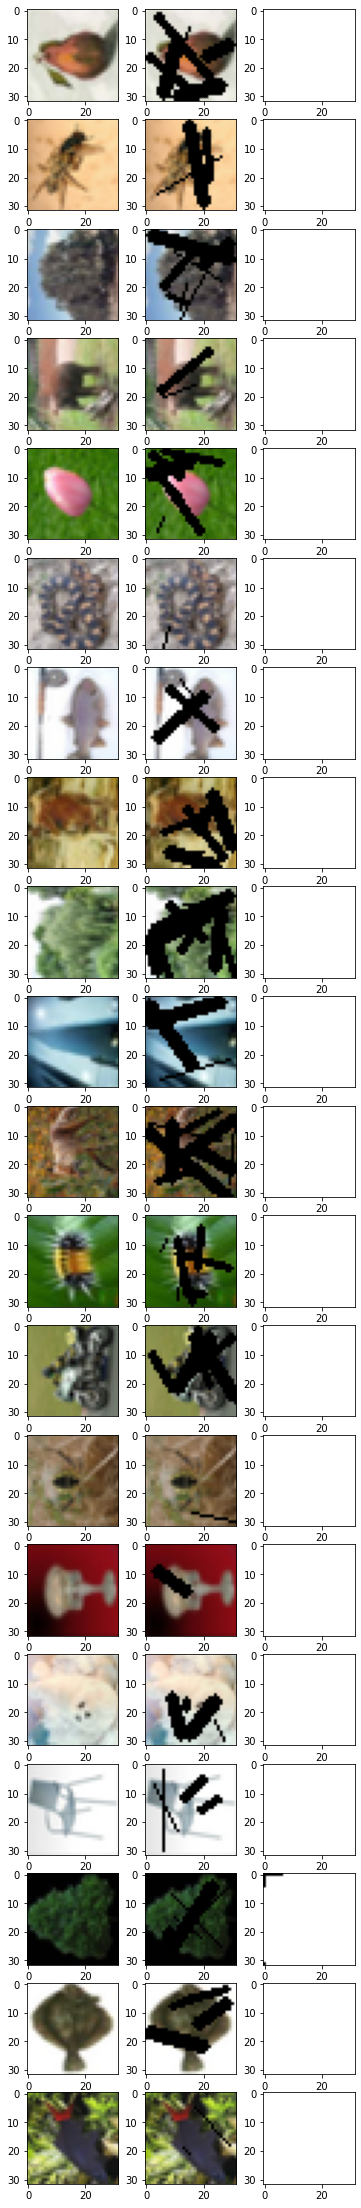

In [45]:
## Examples
# model.load('./encoder_decoder_sgd_50epochs_512batch')
from skimage.metrics import structural_similarity as ssim
import torchgeometry as tgm
rows = 20
sample_idx = 54
sample_images, sample_labels = trainloader[sample_idx]
sample_images, sample_labels=sample_images.to(device), sample_labels.to(device)
ssim_test=[]
fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 2*rows))

for i in range(100,120):
    impainted_image = model(sample_images[i].reshape((1,)+sample_images[i].shape))
    axs[i-100][0].imshow(sample_labels[i].cpu().numpy().T)
    axs[i-100][1].imshow(sample_images[i].cpu().numpy().T)
    axs[i-100][2].imshow(impainted_image[0].detach().cpu().numpy().T)
    
plt.show()
for i in range(len(sample_images)):
    impainted_image = model(sample_images[i].reshape((1,)+sample_images[i].shape))
    ssim_test.append(1-tgm.losses.ssim(impainted_image,sample_images[i].reshape(1,3,32,32),window_size=9).mean().item())
    # ssim_test.append(ssim(sample_labels[i].cpu().numpy(),impainted_image[0].detach().cpu().numpy(),channel_axis=0,multichannel=True))


In [46]:
max(ssim_test)

0.5

In [47]:
sum(ssim_test)/len(ssim_test)

0.5